In [10]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import xgcm
from xorca.lib import load_xorca_dataset
import pickle
import eddytools as et
from cmocean import cm
from scipy.signal import convolve
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
# Obviously it is not a great idea to ignore warnings, however there are quite many
# RuntimeWarnings because of division by 0 in some parts of this notebook. To keep
# the instructive nature of this example notebook, these warnings are ignored.

In [2]:
import time
start_time = time.time()

In [3]:
# detection parameters
Npix_min = 20*6*5
Npix_max = 500*6*5
OW_thr_factor =-0.2

sigma = 9 # smoothing parameter

In [4]:
datestart, dateend = "2012-04-10", "2012-05-04"
#periods = [
#    ("2012-01-01", "2012-01-25"), ("2012-01-26", "2012-02-19"), ("2012-02-20", "2012-03-15"),
#    ("2012-03-16", "2012-04-09"), ("2012-04-10", "2012-05-04"), ("2012-05-05", "2012-05-29"),
#    ("2012-05-30", "2012-06-28"), ("2012-10-27", "2012-11-20"), ("2012-11-21", "2012-12-15"),
#    
#    ("2012-06-29", "2012-07-28"), ("2012-07-29", "2012-08-27"), ("2012-08-28", "2012-09-26"), ("2012-09-27", "2012-10-26"),
#]

In [5]:
#depth= 0  #corresponding to... 
#depth_index = 0 

mesh_mask = xr.open_dataset('/gxfs_work/geomar/smomw355/model_data/ocean-only/INALT60.L120-KRS0020/nemo/suppl/2_INALT60.L120-KRS0020_mesh_mask.nc') 
depth_information = [(round(mesh_mask.nav_lev.values[i]), i) for i in range(0, 64, 3)] #upper 1000m, otherwise: range(0, len(mesh_mask.nav_lev.values), 3)
print(depth_information)

[(0, 0), (4, 3), (10, 6), (18, 9), (27, 12), (39, 15), (54, 18), (71, 21), (91, 24), (114, 27), (141, 30), (173, 33), (210, 36), (253, 39), (304, 42), (365, 45), (437, 48), (525, 51), (629, 54), (753, 57), (899, 60), (1066, 63)]


In [6]:
experiment_name = 'INALT60.L120-KRS0020'
data_resolution = '1d'

### Detection

Things to note for the setting of `detection_parameters`:  
1. `'lon1'` and `'lon2'` need to be in the range (-180, 180). `'lon2'` can be smaller than `'lon1'` if you want to extract work in a region extending across the dateline (e.g. `'lon1': 160`, `'lon2': -170`). 
2. `'OW_thr': data_int` if the field `OW_std` in `data_int` is 2D, i.e. we have a spatially varying standard deviation of the Okubo-Weiss parameter. `'OW_thr': data_int['OW_std'].values` if the field `OW_std` in `data_int` is 1D.  
3. `'OW_thr_factor'` is usually chosen in the range `(-0.5, -0.2)` ([Chelton et al., 2007](https://doi.org/10.1029/2007GL030812); [Isern-Fontanet et al., 2003](https://doi.org/10.1175/1520-0426(2003)20<772:IOMEFA>2.0.CO;2)).

In [7]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': datestart, # time range start
                        'end_time': dateend, # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': 0, # minimum longitude of detection region
                        'lon2': 40, # maximum longitude
                        'lat1': -45, # minimum latitude
                        'lat2': -25, # maximum latitude
                        'min_dep': 100, # minimum ocean depth where to look for eddies in m, masking out areas shallower than value
                        'res': 1./60., # resolution of the fields in degree
                        #'OW_thr': data_int,#['OW_std'].values, # 
                        'OW_thr_name': 'OW_std', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': OW_thr_factor, # Okubo-Weiss parameter threshold
                        'Npix_min': Npix_min, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': Npix_max, # maximum number of pixels (grid cells)
                        'no_long': False, # If True, elongated shapes will not be considered
                        'no_two': False # If True, eddies with two minima in the OW
                                        # parameter and a OW > OW_thr in between  will not
                                        # be considered
                       }

In [8]:
def plot_eddies(data_int, eddies, detection_parameters, datestart, depth):
    """Plot a single time step to see what the detection method detected"""
    t = 0 
    d_p = detection_parameters
    plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.OW.isel(time=t).values,
                   vmin=-1e-9, vmax=1e-9, cmap=cm.balance, shading='auto')
    for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
        plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
                 [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
                 color=c, linestyle=l)
    
    for i in np.arange(0, len(eddies[t])):
        if eddies[t][i]['lon'] < 0:
            eddy_lon = eddies[t][i]['lon'] + 360
        else:
            eddy_lon = eddies[t][i]['lon']
        if eddies[t][i]['type'] == 'cyclonic':
            for s, c in zip([7, 6], ['k', 'gold']):
                plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)
        elif eddies[t][i]['type'] == 'anticyclonic':
            for s, c in zip([7, 6], ['k', 'silver']):
                plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

    plt.title(datestart + ' - ' + str(depth) + 'm')
    plt.show()

  0%|          | 0/22 [00:00<?, ?it/s]

Starting: 20120410, 0m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


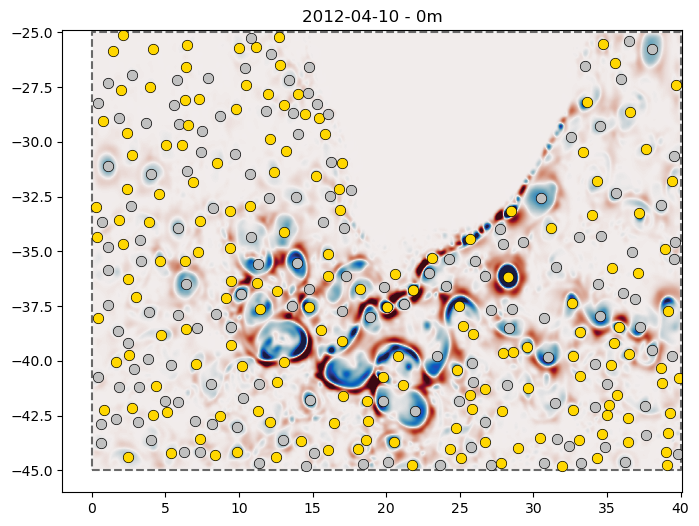

  5%|▍         | 1/22 [01:34<33:03, 94.46s/it]

Starting: 20120410, 4m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


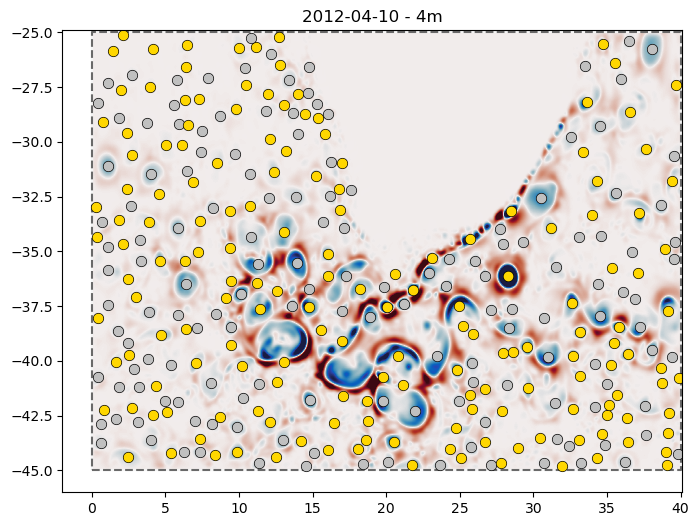

  9%|▉         | 2/22 [03:07<31:09, 93.49s/it]

Starting: 20120410, 10m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


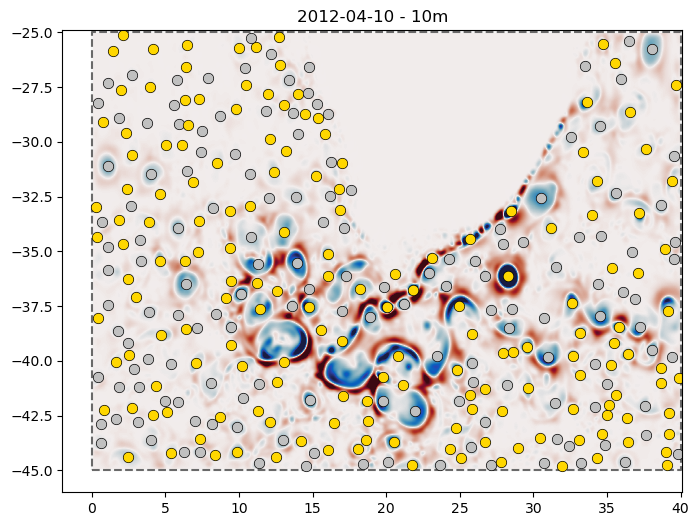

 14%|█▎        | 3/22 [04:39<29:27, 93.01s/it]

Starting: 20120410, 18m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


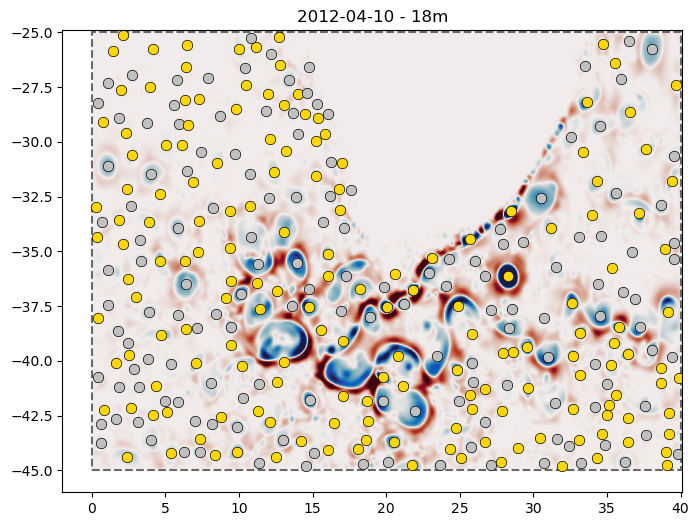

 18%|█▊        | 4/22 [06:12<27:54, 93.04s/it]

Starting: 20120410, 27m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


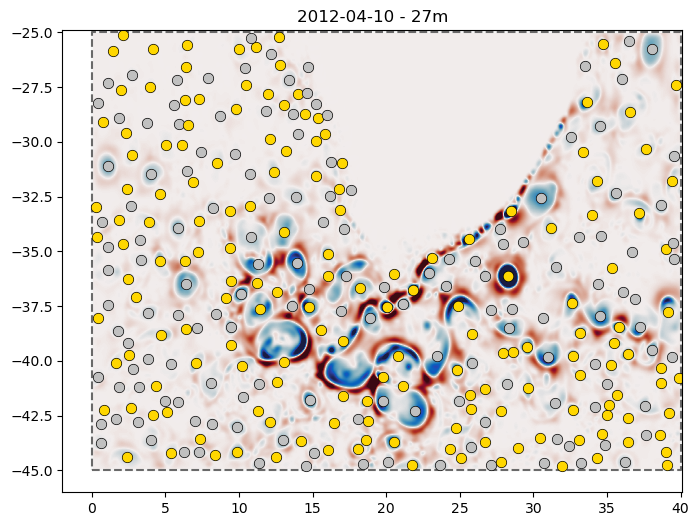

 23%|██▎       | 5/22 [07:47<26:34, 93.77s/it]

Starting: 20120410, 39m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


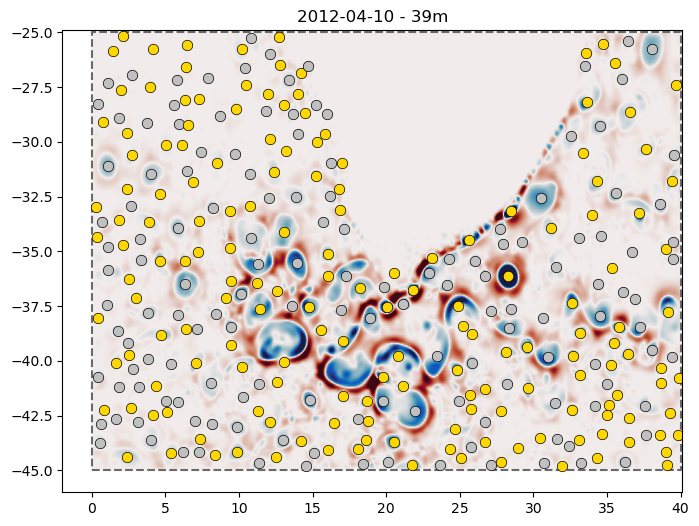

 27%|██▋       | 6/22 [09:20<24:53, 93.37s/it]

Starting: 20120410, 54m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


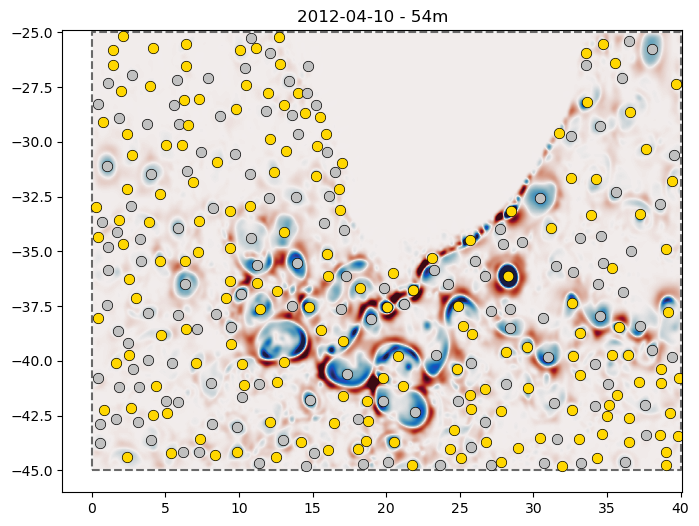

 32%|███▏      | 7/22 [10:51<23:11, 92.75s/it]

Starting: 20120410, 71m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


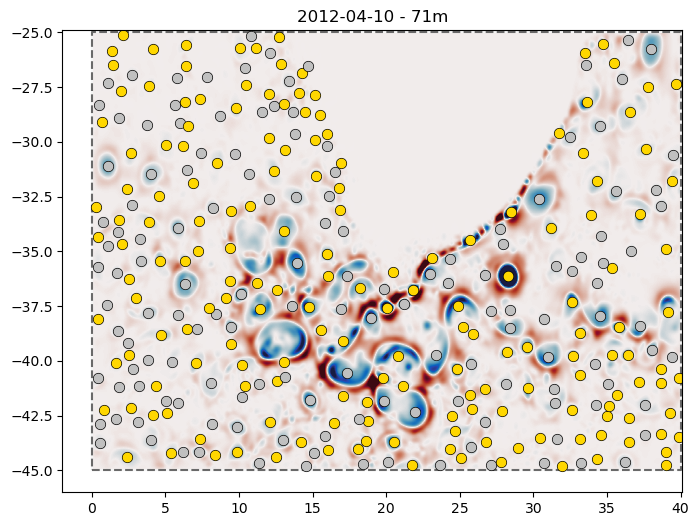

 36%|███▋      | 8/22 [12:21<21:24, 91.72s/it]

Starting: 20120410, 91m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


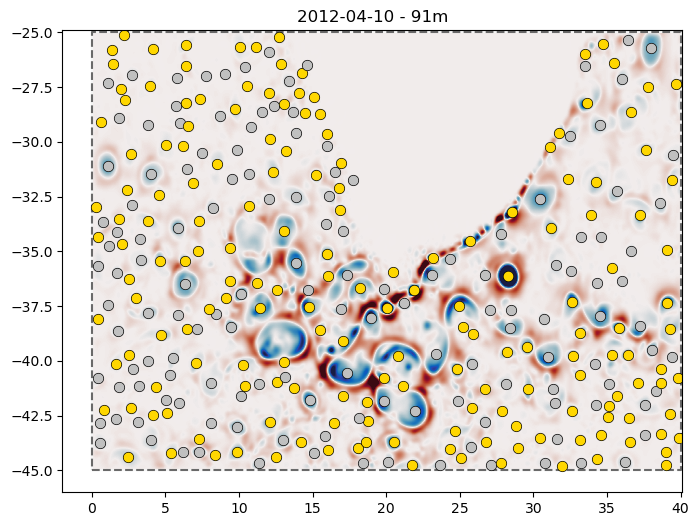

 41%|████      | 9/22 [13:50<19:40, 90.83s/it]

Starting: 20120410, 114m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


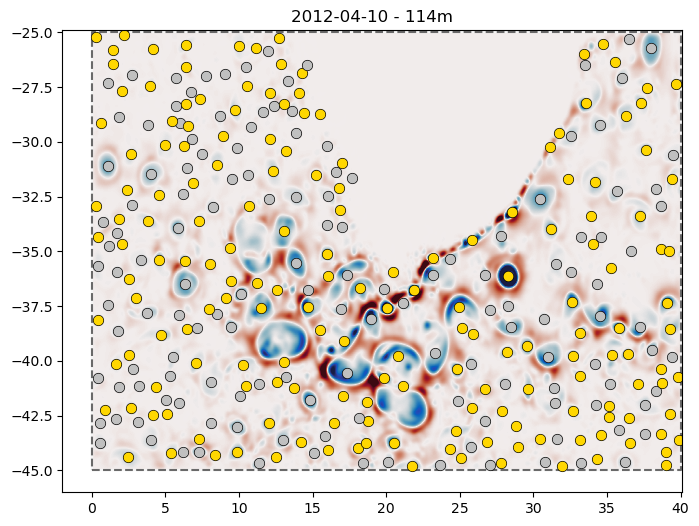

 45%|████▌     | 10/22 [15:19<18:04, 90.40s/it]

Starting: 20120410, 141m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


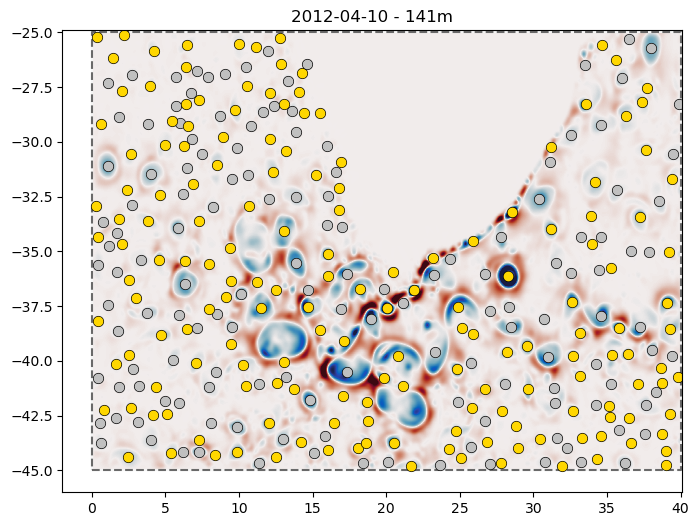

 50%|█████     | 11/22 [16:47<16:25, 89.57s/it]

Starting: 20120410, 173m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


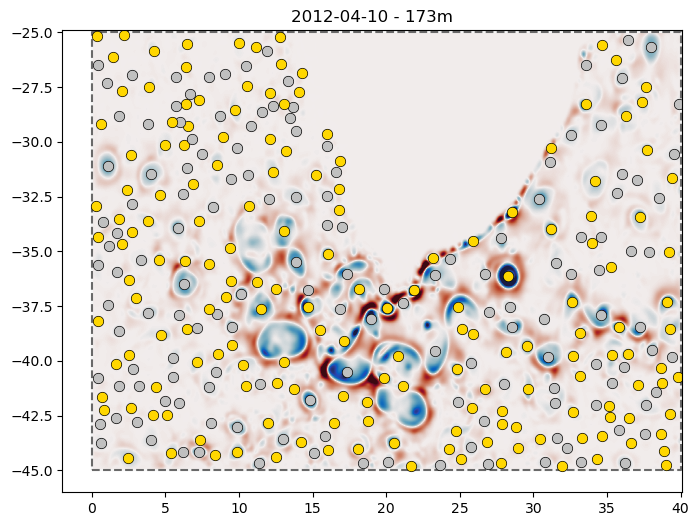

 55%|█████▍    | 12/22 [18:13<14:45, 88.56s/it]

Starting: 20120410, 210m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


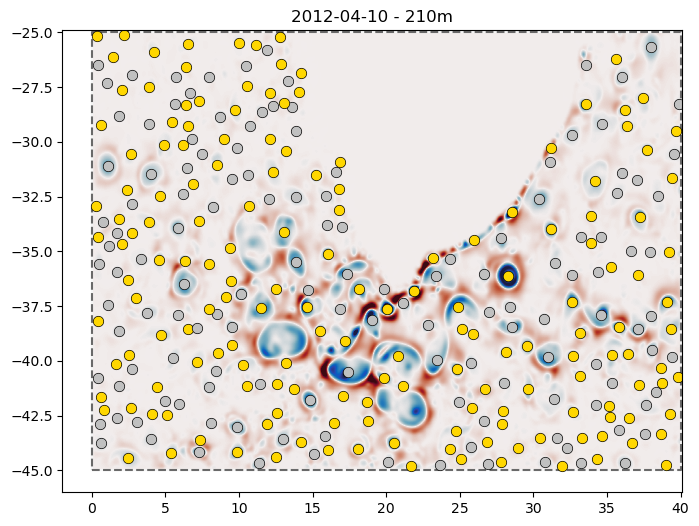

 59%|█████▉    | 13/22 [19:39<13:09, 87.67s/it]

Starting: 20120410, 253m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


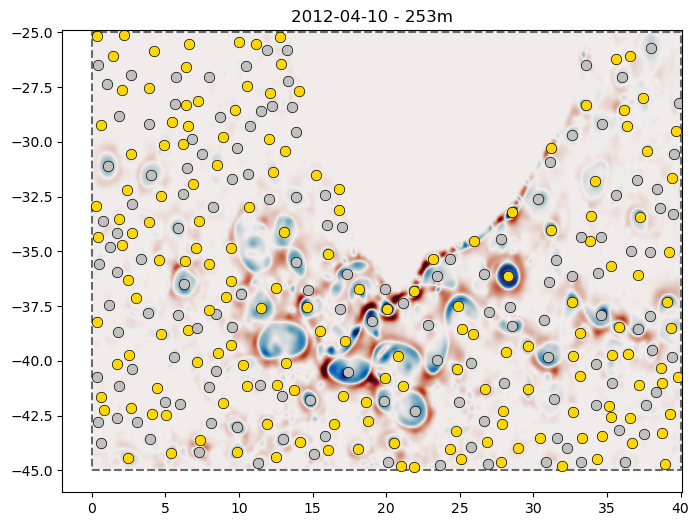

 64%|██████▎   | 14/22 [21:07<11:41, 87.74s/it]

Starting: 20120410, 304m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


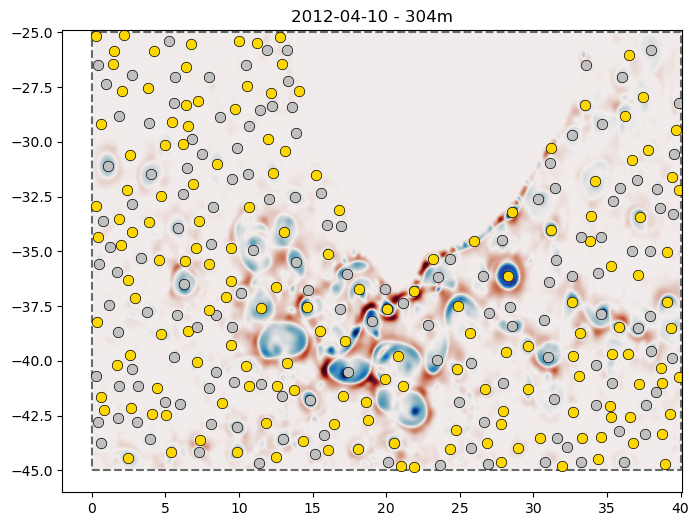

 68%|██████▊   | 15/22 [22:34<10:13, 87.57s/it]

Starting: 20120410, 365m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


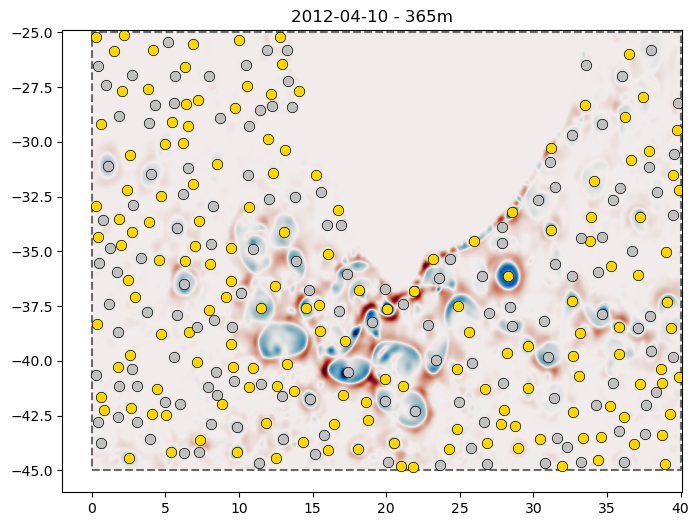

 73%|███████▎  | 16/22 [23:58<08:39, 86.54s/it]

Starting: 20120410, 437m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


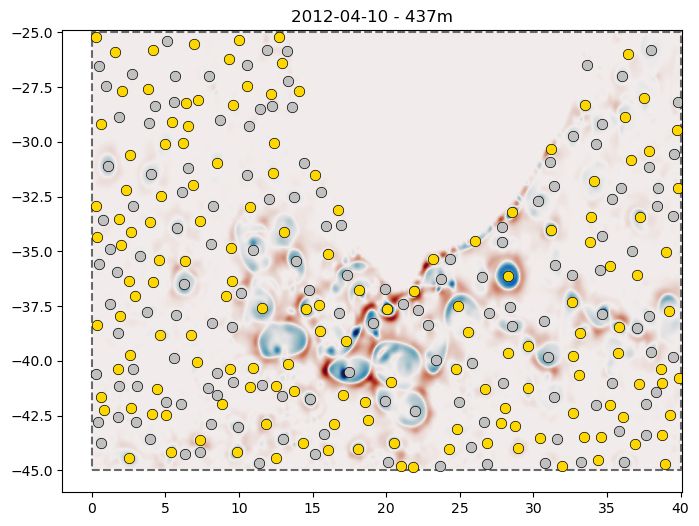

 77%|███████▋  | 17/22 [25:22<07:08, 85.69s/it]

Starting: 20120410, 525m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


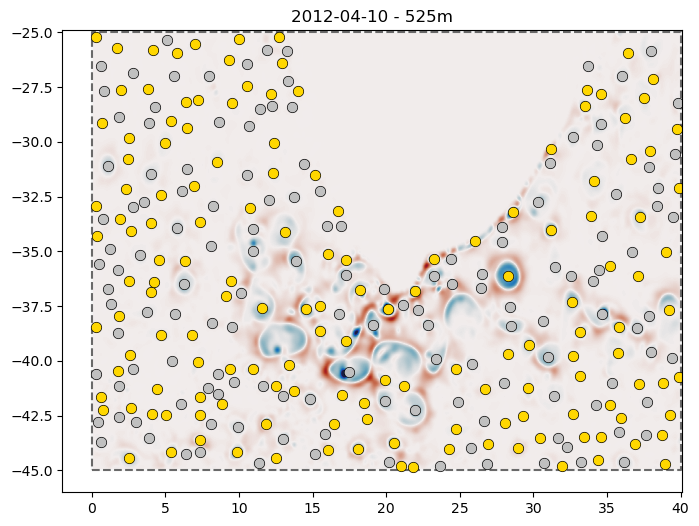

 82%|████████▏ | 18/22 [26:45<05:39, 84.89s/it]

Starting: 20120410, 629m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


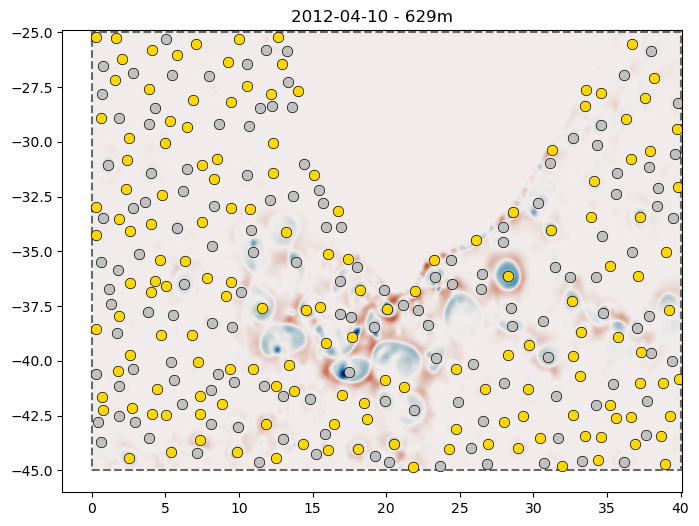

 86%|████████▋ | 19/22 [28:10<04:14, 84.98s/it]

Starting: 20120410, 753m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


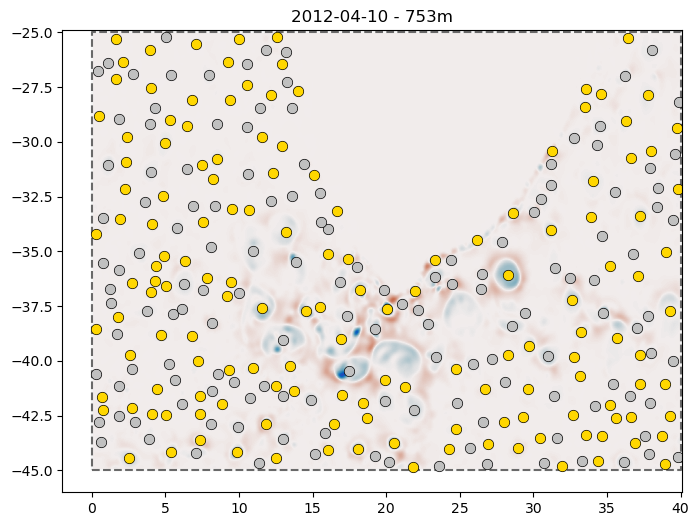

 91%|█████████ | 20/22 [29:35<02:50, 85.12s/it]

Starting: 20120410, 899m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


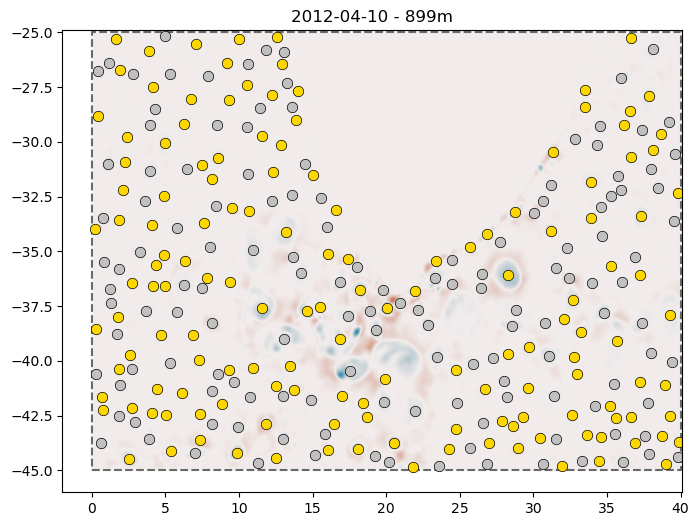

 95%|█████████▌| 21/22 [31:03<01:25, 85.78s/it]

Starting: 20120410, 1066m ...
preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in Okubo-Weiss parameter fields


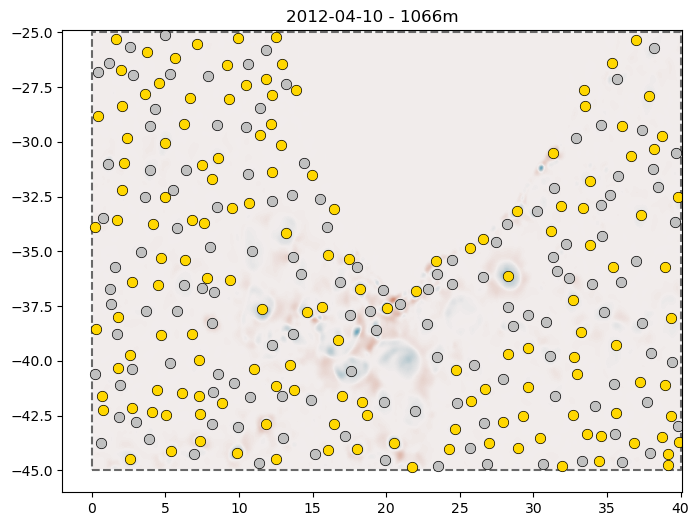

100%|██████████| 22/22 [32:27<00:00, 88.53s/it]


In [12]:
#for (datestart, dateend) in tqdm(periods):
#    print(f"Starting: {datestart.replace("-", "")}-{dateend.replace("-", "")} ...")
for (depth, depth_index) in tqdm(depth_information):
    print(f"Starting: {datestart.replace('-', '')}, {depth}m ...")
    outpath = f'/gxfs_work/geomar/smomw523/eddytools/results/{experiment_name}/smoothed/{sigma}/{data_resolution}/depth-{depth}/'   ## !! SMOOTHED !!
    data_int = xr.open_dataset(outpath + f'OW_{datestart.replace("-", "")}_{dateend.replace("-", "")}.nc')
    detection_parameters['OW_thr'] = data_int

    # We detect eddies at level XX (as we only calculated the Okubo-Weiss parameter at this level)
    eddies = et.detection.detect_OW(data_int.isel(z=depth_index), detection_parameters, 'OW', 'vort', regrid_avoided=False,     
                                    use_bags=False, use_mp=True,mp_cpu=12)
    
    # Plot
    plot_eddies(data_int, eddies, detection_parameters, datestart,depth)

    # Save
    for i in np.arange(0, len(eddies)):
        datestring = str(eddies[i][0]['time'])[0:10] #[0:13] YYYY-MM-DDTHH, e.g. 2012-06-30T02 for 2am at 30 June 2012
        with open(outpath + 'Eddies_' + str(datestring.replace("-", "")) + f'_OW{np.abs(OW_thr_factor)}_Npix-{Npix_min}-{Npix_max}.pickle', 'wb') as f:
            pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
        f.close()


In [13]:
end_time = time.time()

execution_time = end_time - start_time
hours = int(execution_time // 3600)
minutes = int((execution_time % 3600) // 60)
seconds = int(execution_time % 60)

print(f"Execution time: {hours:02}:{minutes:02}:{seconds:02}")

Execution time: 00:35:12
